In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("D:\\Switch\\Projects\\Uplift Modeling\\Data\\criteo-uplift-v2.1.csv")

df = df.sample(n=2_000_000, random_state=42)

X = df.drop(columns=['conversion'])
y = df['conversion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=df[['treatment','conversion']]
)

First Baseline-> Random Targeting

In [4]:
test_df = X_test.copy()
test_df['conversion'] = y_test.values

In [5]:
np.random.seed(42)
test_df['score_random'] = np.random.rand(len(test_df)) #Assigning a random score so that they can be ranked later.

In [6]:
test_df = test_df.sort_values('score_random', ascending=False)

Assuming profit parameters like->
Cost=5$
Profit=40$
The Profit caused by promotion can be calculated

In [7]:
#Profit Function
def compute_profit(df, score_col, cost=5, profit=40):
    
    df = df.sort_values(score_col, ascending=False).reset_index(drop=True)
    
    n = len(df)
    profits = []
    
    for frac in np.linspace(0.01, 1.0, 50):
        
        k = int(frac * n)
        targeted = df.iloc[:k]
        
        treated = targeted[targeted['treatment'] == 1]
        control = targeted[targeted['treatment'] == 0]
        
        conv_treated = treated['conversion'].sum()
        conv_control = control['conversion'].sum()
        
        # Incremental conversions
        if len(control) > 0:
            control_rate = conv_control / len(control) #-> Rate of users getting converted without promo
        else:
            control_rate = 0
        
        #control_rate*len(treated) is just expected baseline conversion
        incremental = conv_treated - control_rate * len(treated)
        
        total_profit = incremental * profit - k * cost
        
        profits.append(total_profit)
    
    return profits

In [8]:
test_df = X_test.copy()
test_df['conversion'] = y_test.values

In [9]:
np.random.seed(42)
test_df['score_random'] = np.random.rand(len(test_df))

In [10]:
random_profits = compute_profit(test_df, 'score_random')

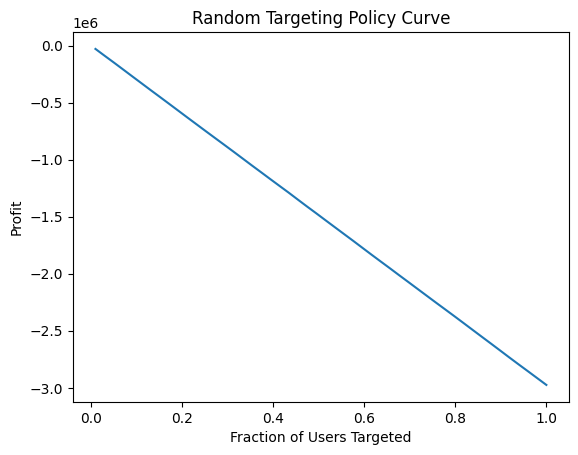

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fractions = np.linspace(0.01, 1.0, 50)

plt.figure()
plt.plot(fractions, random_profits)
plt.xlabel("Fraction of Users Targeted")
plt.ylabel("Profit")
plt.title("Random Targeting Policy Curve")
plt.show()

Targeting more customers looses money. It makes sense as well as ATE is 0.00124.
Expected Profit is 0.00124*40~0.05 < 5.

Conversion Model Targeting. Building a standard classifier ignoring treatment.

In [12]:
features = [col for col in X_train.columns if col != 'treatment']

X_train_model = X_train[features]
X_test_model = X_test[features]

In [13]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_model, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [14]:
test_df = X_test.copy()
test_df['conversion'] = y_test.values

test_df['score_conversion'] = model.predict_proba(X_test_model)[:, 1]

In [15]:
conversion_profits = compute_profit(test_df, 'score_conversion')

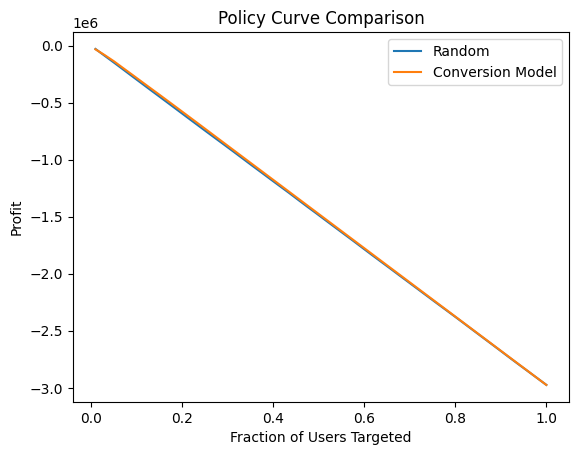

In [16]:
plt.figure()
plt.plot(fractions, random_profits, label="Random")
plt.plot(fractions, conversion_profits, label="Conversion Model")
plt.xlabel("Fraction of Users Targeted")
plt.ylabel("Profit")
plt.title("Policy Curve Comparison")
plt.legend()
plt.show()

VERY INTERESTING. This shows that ranking by conversion Probability does not improve incremenatal Profit. This is because the model likely predicts people which are likely to convert anyway and Not because of the Promo.

Buidling a T-Learner (First Uplift Model)

In [17]:
#Splitting X train by treatment
treated_idx = X_train['treatment'] == 1
control_idx = X_train['treatment'] == 0

X_train_treated = X_train.loc[treated_idx, features]
y_train_treated = y_train.loc[treated_idx]

X_train_control = X_train.loc[control_idx, features]
y_train_control = y_train.loc[control_idx]

In [18]:
model_treated = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_control = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_treated.fit(X_train_treated, y_train_treated)
model_control.fit(X_train_control, y_train_control)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [19]:
mu1 = model_treated.predict_proba(X_test_model)[:, 1]
mu0 = model_control.predict_proba(X_test_model)[:, 1]

test_df['score_t_learner'] = mu1 - mu0

In [20]:
t_learner_profits = compute_profit(test_df, 'score_t_learner')

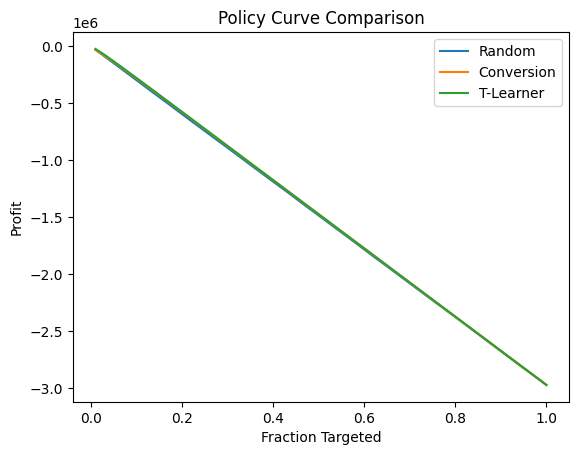

In [21]:
plt.figure()
plt.plot(fractions, random_profits, label="Random")
plt.plot(fractions, conversion_profits, label="Conversion")
plt.plot(fractions, t_learner_profits, label="T-Learner")
plt.xlabel("Fraction Targeted")
plt.ylabel("Profit")
plt.title("Policy Curve Comparison")
plt.legend()
plt.show()

Hm, T-learner~Random~Conversion. Model is not identifying strong heterogeneity. Maybe the economical viability of the constraints is the issue here. Let's try with 100$ Profit.

In [22]:
# Recreate test_df cleanly
test_df = X_test.copy()
test_df['conversion'] = y_test.values

# Random
np.random.seed(42)
test_df['score_random'] = np.random.rand(len(test_df))

# Conversion model
test_df['score_conversion'] = model.predict_proba(X_test_model)[:, 1]

# T-Learner
mu1 = model_treated.predict_proba(X_test_model)[:, 1]
mu0 = model_control.predict_proba(X_test_model)[:, 1]
test_df['score_t_learner'] = mu1 - mu0

In [23]:
COST = 0.5
PROFIT = 100

random_profits_new = compute_profit(test_df, 'score_random', cost=COST, profit=PROFIT)
conversion_profits_new = compute_profit(test_df, 'score_conversion', cost=COST, profit=PROFIT)
t_learner_profits_new = compute_profit(test_df, 'score_t_learner', cost=COST, profit=PROFIT)

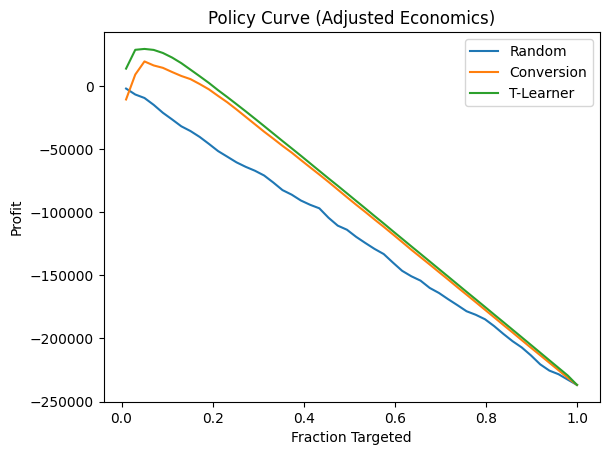

In [24]:
plt.figure()
plt.plot(fractions, random_profits_new, label="Random")
plt.plot(fractions, conversion_profits_new, label="Conversion")
plt.plot(fractions, t_learner_profits_new, label="T-Learner")

plt.xlabel("Fraction Targeted")
plt.ylabel("Profit")
plt.title("Policy Curve (Adjusted Economics)")
plt.legend()
plt.show()

This proves that there is There is heterogeneity. Users behave differently when seeing the promo. That is why model is outperforming others at small fractions.

Training a X-learner next as it is able to handle imabalances better.

In [25]:
# Predict counterfactuals on training data

mu1_train = model_treated.predict_proba(X_train_model)[:, 1]
mu0_train = model_control.predict_proba(X_train_model)[:, 1]

# Initialize tau
tau = np.zeros(len(X_train))

# For treated units
tau[treated_idx] = y_train_treated.values - mu0_train[treated_idx]

# For control units
tau[control_idx] = mu1_train[control_idx] - y_train_control.values

In [26]:
from xgboost import XGBRegressor
effect_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

effect_model.fit(X_train_model, tau)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [27]:
test_df['score_x_learner'] = effect_model.predict(X_test_model)

In [28]:
x_learner_profits = compute_profit(test_df, 'score_x_learner', cost=COST, profit=PROFIT)

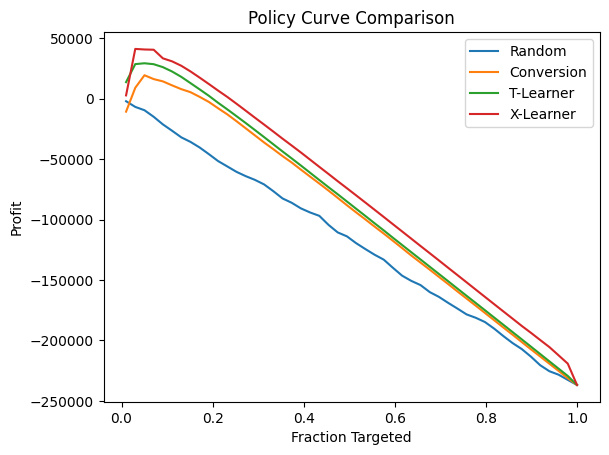

In [29]:
plt.figure()
plt.plot(fractions, random_profits_new, label="Random")
plt.plot(fractions, conversion_profits_new, label="Conversion")
plt.plot(fractions, t_learner_profits_new, label="T-Learner")
plt.plot(fractions, x_learner_profits, label="X-Learner")

plt.xlabel("Fraction Targeted")
plt.ylabel("Profit")
plt.title("Policy Curve Comparison")
plt.legend()
plt.show()

Excellent.

In [30]:
output = test_df[['treatment', 'conversion',
                  'score_random',
                  'score_conversion',
                  'score_t_learner',
                  'score_x_learner']]

output.to_csv("D:\\Switch\\Projects\\Uplift Modeling\\outputs\\test_predictions.csv", index=False)

C:\Users\Garvit Chandel\AppData\Local\Temp\ipykernel_17856\1542244798.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_model[:5000])


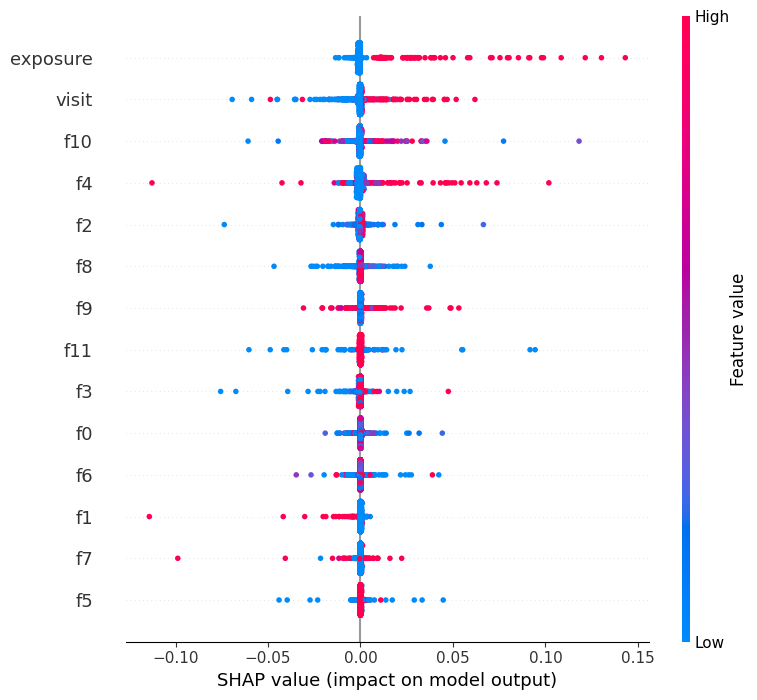

In [31]:
import shap

explainer = shap.TreeExplainer(effect_model)
shap_values = explainer.shap_values(X_test_model[:5000])

shap.summary_plot(shap_values, X_test_model[:5000])

High exposure is the leading factor. Users who spend more time in interacting with the service are the most likely to response positively to the promo.
The dots on the left side indicate that some users react negatively to it as well.
